
#<center> Project 4 : </center>
#<center>Sea level rise (global analysis) </center>
####<center> LIU Kehan </center>
####<center> Brahim Ouhammou </center>
####<center> Clément Béliveau </center>
####<center> Hortense Ronzani </center>  
The project aims to assess and predict sea level rise by analyzing sea surface height (SSH) time series data. The main objective is to  provide insights into both global and local patterns of sea level rise, offering a comprehensive view of the potential impacts in different regions.  
##There are two main goals:  
###1.Projected global sea level rise
###2.Plotting the local slopes of different SSH time series around the globe


In [ ]:
!pip install Basemap

In [ ]:
import xarray as xr
import sys
import gcsfs

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Collect to GCP

In [ ]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

## Load the data

In [ ]:
%%bigquery output --project alert-ground-261008
SELECT time, AVG(ssh) AS mean_ssh , STDDEV(ssh) AS std_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat> -35 AND lat<35
GROUP BY time
order BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
%%bigquery output_global --project alert-ground-261008
SELECT time, AVG(ssh) AS mean_ssh , STDDEV(ssh) AS std_ssh
FROM bdo2020.bdo2020.1998_2015
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
data_15 = output
data_15

time  mean_ssh   std_ssh
0     729390.0  0.778453  0.263949
1     729391.0  0.777943  0.263705
2     729392.0  0.777465  0.263482
3     729393.0  0.776976  0.263234
4     729394.0  0.776502  0.262949
...        ...       ...       ...
6569  735959.0  0.841837  0.267267
6570  735960.0  0.841651  0.267094
6571  735961.0  0.841408  0.266813
6572  735962.0  0.841080  0.266444
6573  735963.0  0.840709  0.266034

[6574 rows x 3 columns]

## Plot the data

In [ ]:
# function to plot images
def plot_im(lon,lat,im,size_points,var_name):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name, alpha=None, label=None):

    # plot
    plot_date(time-719177.25,ts,line_type, alpha = alpha, label= label)  # time = number of day starting from jan first of the first year
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)
    plt.legend()


In [ ]:
## We normalize the data
mean_ssh = np.array(output_global.mean_ssh[5*365:]) - 0.34*np.ones((1, len(output_global.mean_ssh[5*365:])))[0]
time = output_global.time[5*365:]

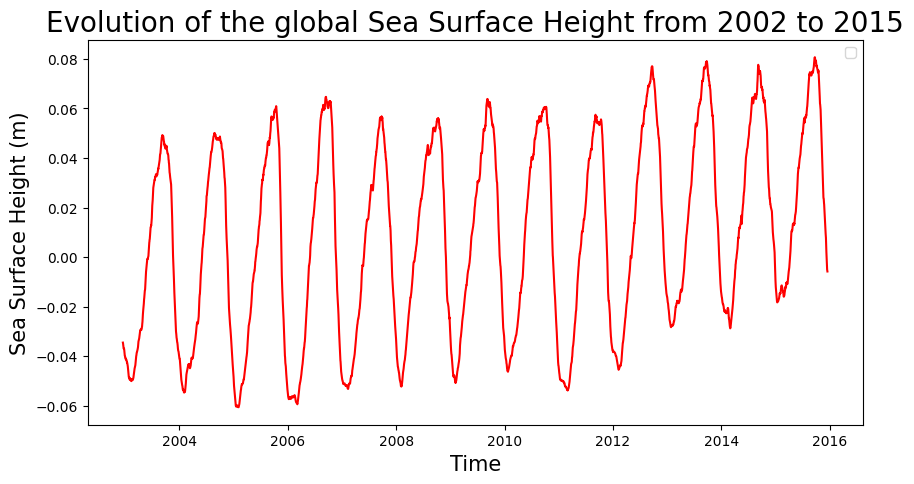

In [ ]:
# plot the data retreived from big querry

plt.figure(figsize=(10, 5))
plot_ts(time, mean_ssh, 'red','Sea Surface Height (m)')
plt.title('Evolution of the global Sea Surface Height from 2002 to 2015', fontsize=20)
plt.legend()

## Fitting of the model

We recreate this signal with known functions. We try sinus and cosinus as regressors for the seasonal pattern, and linear and exponential for the trend.

In [ ]:
# Seasonal trend
sin = np.sin(2 * np.pi * (1/365) * time)
cos = np.cos(2 * np.pi * (1/365) * time)

# Prepare input for prediction
X_ssh = np.column_stack([time, sin, cos])

## Model creation
model_rise1 = LinearRegression().fit(X_ssh, mean_ssh[:,None])

# Predict using the model
ssh_predicted1 = model_rise1.predict(X_ssh)

print('Model coefficients for [t, sin, cos]: {}'.format(model_rise1.coef_))
print('Model coefficient for b: {}'.format(model_rise1.intercept_))

Model coefficients for [t, sin, cos]: [[7.24542170e-06 8.12924393e-03 5.08885502e-02]]
Model coefficient for b: [-5.306972]


Model coefficients for [a1, a2, a3]: [[1.77880031 0.00812906 0.05088843]]
Model coefficient for b: [-5.06477483]


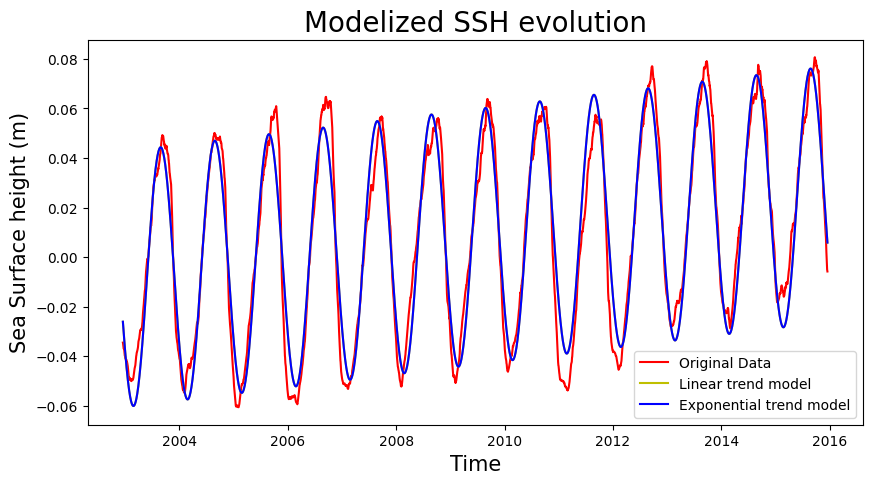

In [ ]:
# Define time range up to 2150

# Seasonal trend
exp = np.exp(time/700000)
sin = np.sin(2 * np.pi * (1/365) * time)
cos = np.cos(2 * np.pi * (1/365) * time)

# Prepare input for prediction
X_ssh2 = np.column_stack([exp, sin, cos])

## Model creation
model_rise2 = LinearRegression().fit(X_ssh2, mean_ssh[:,None])

# Predict using the model
ssh_predicted2 = model_rise2.predict(X_ssh2)

print('Model coefficients for [a1, a2, a3]: {}'.format(model_rise2.coef_))
print('Model coefficient for b: {}'.format(model_rise2.intercept_))


# plot global SST and SSH time series
plt.figure(figsize=(10,5))
plot_ts(time, mean_ssh      , '-r', 'Sea Surface height (m)', label="Original Data ")
plot_ts(time, ssh_predicted1, '-y', 'Sea Surface height (m)', label="Linear trend model")
plot_ts(time, ssh_predicted2, '-b', 'Sea Surface height (m)', label="Exponential trend model")
plt.title("Modelized SSH evolution", fontsize=20)
plt.legend()

## Prediction until 2100

We now extrapolate our model to 2100, trying to predict future sea level rise.

In [ ]:
# Period of prediction
start_value = 729390.0 + 5*365
end_value = 734138.0+365*(2100-2011)
step = 1

# Generate the range of values using numpy
values = np.arange(start_value, end_value + step, step)

# Create a DataFrame with the generated values
df_time = pd.DataFrame({'time': values})

# Seasonal trend
# Seasonal trend
exp = np.exp(df_time/700000)
sin = np.sin(2 * np.pi * (1/365) * df_time)
cos = np.cos(2 * np.pi * (1/365) * df_time)

# Prepare input for prediction
X_ssh_1 = np.column_stack([df_time, sin, cos])
X_ssh_2 = np.column_stack([exp, sin, cos])

# Predict using the model
ssh_predicted1 = model_rise1.predict(X_ssh_1)
ssh_predicted2 = model_rise2.predict(X_ssh_2)

In [ ]:
# Find the average of the model in 2100, meaning only using the first coefficent
day_2100 = 365*(2100-1970)
y_2100   = model_rise1.coef_[0]*day_2100 + model_rise1.intercept_

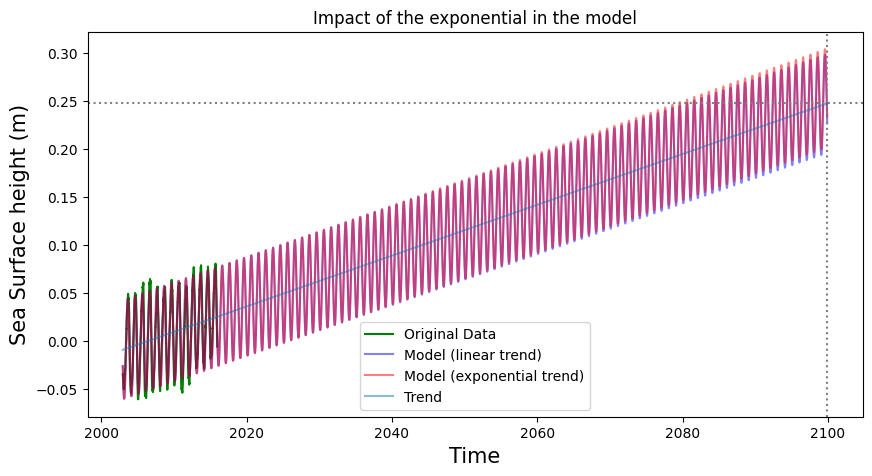

In [ ]:
# plot global SST and SSH time series
plt.figure(figsize=(10,5))

plot_ts(time  ,mean_ssh       ,'-g','Sea Surface height (m)', label="Original Data ")
plot_ts(df_time    ,ssh_predicted1 ,'-b','Sea Surface height (m)', label="Model (linear trend)", alpha=0.5)
plot_ts(df_time    ,ssh_predicted2 ,'-r','Sea Surface height (m)', label="Model (exponential trend)", alpha=0.5)
plt.axvline(day_2100, color='grey', linestyle=':')  # Add vertical line at t = 2100


# trend
trend = model_rise1.coef_[0][0]*np.array(df_time).T[0] + model_rise1.intercept_[0]*np.ones((1, len(np.array(df_time)))) #-  0.34*np.ones((1, len(np.array(df))))
plt.axhline(trend[0][-1], color='grey', linestyle=':')  # Add horizontal line at y = y_2100
plot_ts(np.array(df_time).T[0],trend[0] ,'-','Sea Surface height (m)', label="Trend", alpha=0.5)

plt.title('Impact of the exponential in the model')
plt.show()


We can see that there are almost no differences between a linear and an exponential interpolation, so for the end of the project we will stick to a linear model.

## Uncertainty

Now we want to compute the incertainty of our predictions as a function of time.

$$
\begin{align}
&\text{We have } SSH(t) = T(t) + S(t) + \epsilon(t) \textit{   (1)}\\
&\text{such that   }    \epsilon(t) = \Phi\epsilon(t-1) +\eta(t) \textit{   (2)}\\   
&\text{ and    }        \eta(t)\sim\mathcal{N}(0,\sigma^2), Cov(\eta(t), \eta(t-1)) = 0 \textit{   (3)}
\end{align}
$$

$$
E(SSH(t)) = E(T(t) + S(t) + \epsilon(t))
          = T(t) + S(t)
$$

$$
\begin{align}
Var(SSH(t))  &= Var(T(t) + S(t) + \epsilon(t))\\
             &= Var(T(t)) + Var(S(t)) + Var(\epsilon(t))\\
             &= Var(\epsilon(t))\\
             &= Var(\Phi\epsilon(t-1) +\eta(t))\\
             &= \Phi^2 Var(\epsilon(t-1)) + \sigma^2 \\
             &= \Phi^4 Var(\epsilon(t-2)) + \Phi^2 \sigma^2 + \sigma^2 \\
             &\text{....} \\
             &= \Phi^2t Var(\epsilon(0)) + \sigma^2 \sum_{i=0}^{t-1}\Phi^{2t} \\
\end{align}
$$

$$
\begin{align}
&\text{In our case: }   \Phi = 1 \\
&\text{Then : }         Var(SSH(t)) = tVar(\epsilon(0)) + t\sigma^2    \textit{   (4)}
\end{align}
$$

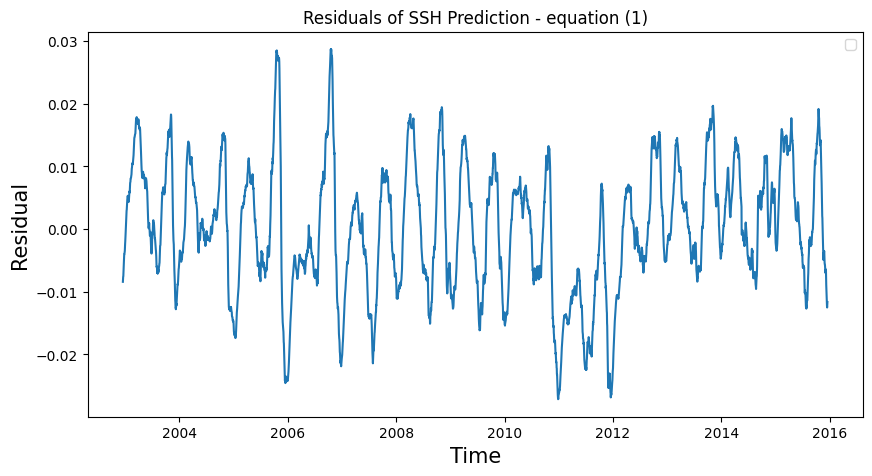

In [ ]:
#t = data_15.time
ssh_mesured = np.array(mean_ssh)
ssh_predicted = model_rise1.predict(X_ssh).T

# compute the redidute
epsilon = ssh_mesured-ssh_predicted[0]
plt.figure(figsize=(10,5))
plt.title('Residuals of SSH Prediction - equation (1)')
plot_ts(time, epsilon, '-', 'Residual' )

Text(0.5, 1.0, 'Epsilon of t in fonction of Epsilon t-1 - equation (2)')

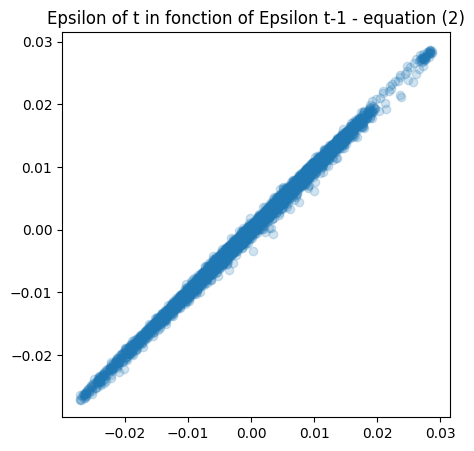

In [ ]:
plt.figure(figsize=(5,5))
epsilon_t_1 = epsilon[:-1]
epsilon_t = epsilon[1:]
plt.scatter(epsilon_t_1, epsilon_t, alpha=0.2)
plt.title("Epsilon of t in fonction of Epsilon t-1 - equation (2)")

In [ ]:
## Now we compute the regression of phi(t-1) in function of phi(t)

model_phi = LinearRegression().fit(epsilon_t_1[:,None], epsilon_t[:,None])
phi = model_phi.coef_
print('Model coefficients of phi: {}'.format(phi))
print('Model coefficient for b: {}'.format(model_phi.intercept_))

Model coefficients of phi: [[0.99858687]]
Model coefficient for b: [-6.75320817e-07]


> Phi is almost equal to one, so it is one

In [ ]:
eta = epsilon_t - phi*epsilon_t_1
eta = eta[0]

mean  -6.753208165771413e-07
standard deviation (sigma)  0.0005575125265518255 



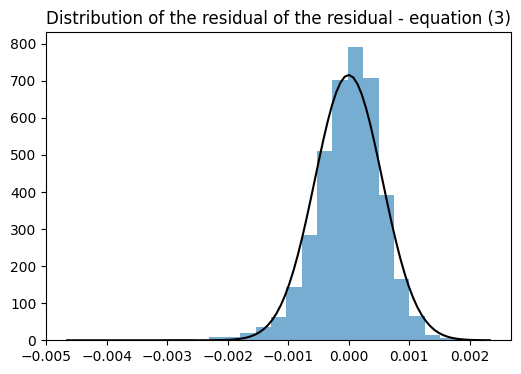

In [ ]:
from scipy.stats import norm
plt.figure(figsize=(6,4))

sigma   = np.var(eta)
mu, std = norm.fit(eta)

# hitogram
plt.hist(eta, bins=25, density=True, alpha=0.6)
xmin , xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
print("mean ", mu)
print("standard deviation (sigma) ", std, "\n")
plt.title("Distribution of the residual of the residual - equation (3)")
plt.plot(x, p , 'k')

In [ ]:
# Compute the variance for each time step of the prediction period
from tqdm import tqdm
var_ssh = []
for t in tqdm(range(1, len(df_time["time"]))):
  a = np.var(epsilon_t) + t*(std)**2
  var_ssh.append(a)

100%|██████████| 35408/35408 [00:02<00:00, 15283.74it/s]


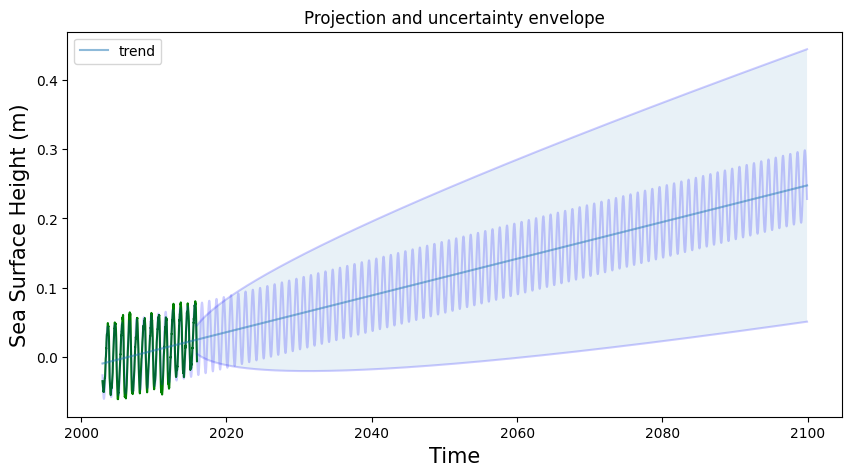

In [ ]:
# plot global SST and SSH time series
plt.figure(figsize=(10,5))

plot_ts(time,mean_ssh       ,'-g','Sea Surface Height (m)')
plot_ts(df_time  ,ssh_predicted1 ,'-b','Sea Surface Height (m)', alpha=0.2)
plot_ts(np.array(df_time).T[0],trend[0] ,'-','Sea Surface Height (m)', label="trend", alpha=0.5)

a = len(ssh_predicted1[1:]) -len(output_global.time)

new_time            = df_time[len(time):]
ssh_predicted_chunk = ssh_predicted1[len(time):]
var_ssh_chunk = np.array(var_ssh[0:len(ssh_predicted)-len(time)])[:,None]



positive_int = trend[0][len(mean_ssh):] +  2*np.sqrt(var_ssh_chunk).T[0]
negative_int = trend[0][len(mean_ssh):] -  2*np.sqrt(var_ssh_chunk).T[0]

plot_ts(new_time, positive_int ,'-b','Sea Surface Height (m)', alpha=0.2)
plot_ts(new_time, negative_int ,'-b','Sea Surface Height (m)', alpha=0.2)

plt.title('Projection and uncertainty envelope')

plt.fill_between(list(new_time['time'] -719177.25), positive_int , negative_int , alpha=0.1, label='SSh Std Dev')


# Comparison with CMIP6 members

In [ ]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2024/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"),
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    check_up_env()
from intake import open_catalog
import intake

In [ ]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')
df_full = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_full.sample(10)

activity_id institution_id       source_id       experiment_id  \
480157        PAMIP           NCAR  CESM1-WACCM-SC  pdSST-futArcSICSIT   
173049         DCPP          CCCma         CanESM5      dcppA-hindcast   
56366         CFMIP           NCAR           CESM2            amip-p4K   
522665  ScenarioMIP          CSIRO   ACCESS-ESM1-5              ssp585   
480723        PAMIP           NCAR  CESM1-WACCM-SC            pa-pdSIC   
510221        PAMIP   CNRM-CERFACS      CNRM-CM6-1         pdSST-pdSIC   
2402    ScenarioMIP      NOAA-GFDL        GFDL-CM4              ssp245   
507578         CMIP            CAS      CAS-ESM2-0          historical   
243546         CMIP           NCAR           CESM2       esm-piControl   
479738        PAMIP           NCAR  CESM1-WACCM-SC     pdSST-futAntSIC   

         member_id table_id variable_id grid_label  \
480157  r271i1p1f1     Amon     sfcWind         gn   
173049   r14i1p2f1     Amon         prw         gn   
56366     r1i1p1f1     Amon          o3         gn   
522665   r16i1p1f1     Amon        rlut         gn   
480723   r17i1p1f1     Amon         psl         gn   
510221   r81i1p1f2     Amon          pr         gr   
2402      r1i1p1f1      Oyr     bddtdic         gr   
507578    r1i1p1f1     Omon         wmo         gn   
243546    r1i1p1f1     Omon   spco2abio         gn   
479738   r64i1p1f1     Amon          ps         gn   

                                                   zstore  dcpp_init_year  \
480157  gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/pdS...             NaN   
173049  gs://cmip6/DCPP/CCCma/CanESM5/dcppA-hindcast/s...          2013.0   
56366   gs://cmip6/CMIP6/CFMIP/NCAR/CESM2/amip-p4K/r1i...             NaN   
522665  gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1...             NaN   
480723  gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/pa-...             NaN   
510221  gs://cmip6/CMIP6/PAMIP/CNRM-CERFACS/CNRM-CM6-1...             NaN   
2402    gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...             NaN   
507578  gs://cmip6/CMIP6/CMIP/CAS/CAS-ESM2-0/historica...             NaN   
243546  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/esm-piControl...             NaN   
479738  gs://cmip6/CMIP6/PAMIP/NCAR/CESM1-WACCM-SC/pdS...             NaN   

         version  
480157  20201012  
173049  20190429  
56366   20190302  
522665  20210714  
480723  20201012  
510221  20210106  
2402    20180701  
507578  20201228  
243546  20190723  
479738  20201012

Predicted SSH changes between 2015 and 2100 from CMIP6 obtained from different models under 'ssp126 and 'ssp585' conditions.
We selected 20 models for each condition.

In [ ]:
# Choice of the CMIP6 models
A = ['ssp126', 'ssp585']

# Stores processed data for each dataset
all_zostoga_values = []
time_values_length = None

for i in A:
    for m in range(20):
        cond = "(variable_id=='zostoga' & table_id == 'Omon' & experiment_id=='" + i + "') "

        df = df_full.query(cond)  # Horizontal resolution up to 1deg
        df = df.sort_values('version', ascending=False)

        # get the path to a specific zarr store (the first one from the dataframe above)
        zstore = df.zstore.values[m]
        print(zstore)

        # create a mutable-mapping-style interface to the store
        gcs = gcsfs.GCSFileSystem(token='anon')
        mapper = gcs.get_mapper(zstore)

        # open it using xarray and zarr
        ds = xr.open_zarr(mapper, consolidated=True)
        print("Size of the dataset:", ds.nbytes / 1e9, "Gb")

        # Subtract the first value of zostoga from all values and store in the list
        processed_values = ds.zostoga.values - ds.zostoga.values[0]+0.02272397

        # If it is the first iteration, record the length of the timeline
        if time_values_length is None:
            time_values_length = len(ds.time)

        # Check if the timeline length is consistent, if not then truncate or padding
        if len(ds.time) != time_values_length:
            processed_values = processed_values[:time_values_length]

        all_zostoga_values.append(processed_values)




gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg-LR/ssp126/r3i1p1f1/Omon/zostoga/gn/v20201201/
Size of the dataset: 2.8896e-05 Gb
gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg-LR/ssp126/r2i1p1f1/Omon/zostoga/gn/v20201201/
Size of the dataset: 2.8896e-05 Gb
gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg-LR/ssp126/r1i1p1f1/Omon/zostoga/gn/v20201201/
Size of the dataset: 2.8896e-05 Gb
gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r5i1p1f2/Omon/zostoga/gm/v20201015/
Size of the dataset: 2.8896e-05 Gb
gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r7i1p1f2/Omon/zostoga/gm/v20201015/
Size of the dataset: 2.8896e-05 Gb
gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r6i1p1f2/Omon/zostoga/gm/v20201009/
Size of the dataset: 2.8896e-05 Gb
gs://cmip6/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31-MM/ssp126/r1i1p1f3/Omon/zostoga/gm/v20201006/
Size of the dataset: 2.8896e-05 Gb
gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp12

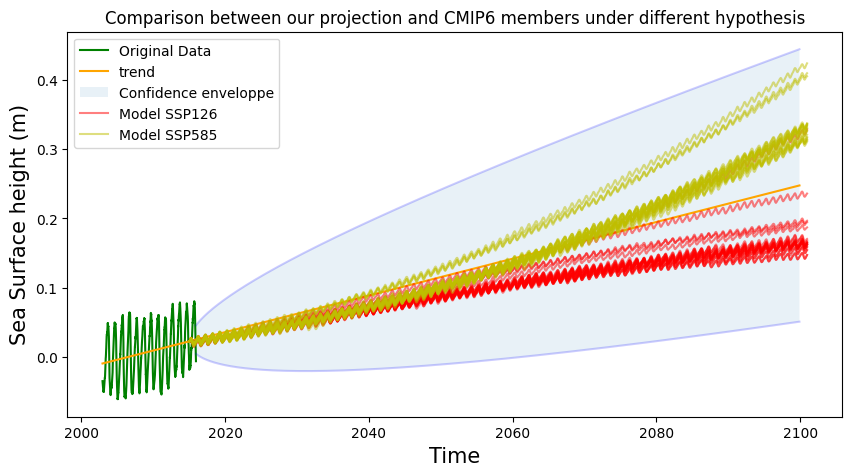

In [ ]:
plt.figure(figsize=(10, 5))

plot_ts(time,mean_ssh       ,'-g','Sea Surface height (m)', label="Original Data")
#plot_ts(df_time  ,ssh_predicted1 ,'-b','Sea Surface height (m)', alpha=0.3, label="Prediction of SSH")
plot_ts(np.array(df_time).T[0],trend[0] ,'orange','Sea Surface height (m)', label="trend", alpha=1)

a = len(ssh_predicted1[1:]) -len(data_15.time)

new_time            = df_time[len(time):]
ssh_predicted_chunk = ssh_predicted1[len(time):]
var_ssh_chunk = np.array(var_ssh[0:len(ssh_predicted)-len(time)])[:,None]



positive_int = trend[0][len(mean_ssh):] +  2*np.sqrt(var_ssh_chunk).T[0]
negative_int = trend[0][len(mean_ssh):] -  2*np.sqrt(var_ssh_chunk).T[0]

plot_ts(new_time, positive_int ,'-b','Sea Surface height (m)', alpha=0.2, label="")
plot_ts(new_time, negative_int ,'-b','Sea Surface height (m)', alpha=0.2, label="")


plt.fill_between(list(new_time['time'] -719177.25), positive_int , negative_int , alpha=0.1, label='Confidence enveloppe')

plt.plot(ds.time, all_zostoga_values[0],'r', alpha=0.5, label="Model SSP126")
plt.plot(ds.time, all_zostoga_values[-1],'y', alpha=0.5, label="Model SSP585")

plt.legend()
#  Plot all curves at once
for i in range(len(all_zostoga_values)):
  if i <= 20 :
    plt.plot(ds.time, all_zostoga_values[i],'r', alpha=0.5, label="Model SSP126")
  else:
    plt.plot(ds.time, all_zostoga_values[i],'y', alpha=0.5, label="Model SSP585")

plt.title("Comparison between our projection and CMIP6 members under different hypothesis")
plt.show()

The CMIP6 members are all in our confidence envelope, and our deterministic projection is between the low-carbon emissions scenario (red) and the high-carbon emissions scenario (yellow).

# Spatial variations of sea level rise

Sea level is not rising homogeneously on the entire globe. We now want to visualize this spatial variability, by plotting the driving coefficient of the regression line. We choose to compute the variation between the mean sea level of 1998 and the mean sea level of 2015, for each pixel. It is done remotely with Big Query:

In [ ]:
%%bigquery output2 --project alert-ground-261008
WITH MinMaxTime AS (
SELECT lon, lat, MIN(year) as minTime, MAX(year) as maxTime
FROM bdo2020.bdo2020.1998_2015_withtimes
GROUP BY lon, lat),

 Minssh AS ( SELECT A.lon, A.lat, AVG(A.ssh) AS avg_ssh_min
FROM MinMaxTime M INNER JOIN bdo2020.bdo2020.1998_2015_withtimes A ON (M.lon = A.lon AND M.lat = A.lat AND M.minTime = A.year)
GROUP BY A.lon, A.lat)
,
 Maxssh AS ( SELECT A.lon, A.lat, AVG(A.ssh) AS avg_ssh_max
FROM MinMaxTime M INNER JOIN bdo2020.bdo2020.1998_2015_withtimes A ON (M.lon = A.lon AND M.lat = A.lat AND M.maxTime = A.year)
GROUP BY A.lon, A.lat)

SELECT t1.lon, t1.lat, (- t1.avg_ssh_min + t2.avg_ssh_max)/18  AS slope
FROM Minssh t1 INNER JOIN Maxssh t2 ON (t1.lon = t2.lon AND t1.lat = t2.lat)

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
output2

lon     lat     slope
0       338.125 -39.875  0.003074
1       250.375 -65.875 -0.004315
2       124.125 -61.375  0.003652
3         8.625  70.625 -0.002172
4       156.125 -48.125  0.006550
...         ...     ...       ...
563962   76.875  82.875  0.001433
563963  331.875 -70.625  0.001327
563964  177.875 -74.875  0.000225
563965  331.375 -73.625 -0.000078
563966  336.125 -67.875  0.001883

[563967 rows x 3 columns]

Here is the result:

Text(0.5, 1.0, 'Sea level rise speed between 1998 and 2015')

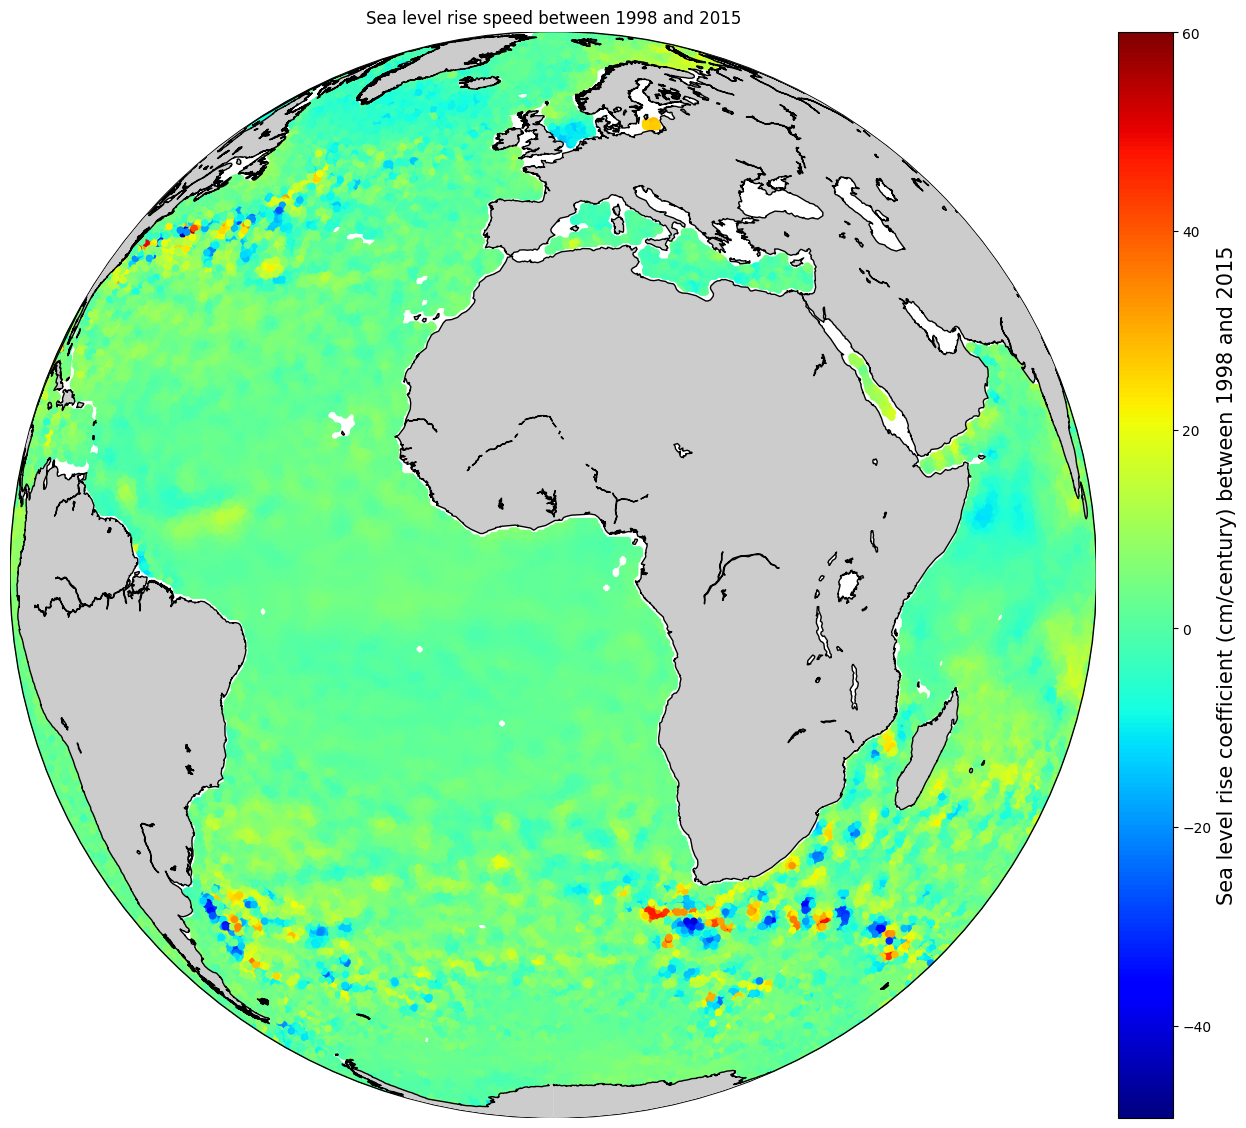

In [ ]:
plot_im(output2.lon, output2.lat, output2.slope*1000, 30, "Sea level rise coefficient (cm/century) between 1998 and 2015")
plt.title("Sea level rise speed between 1998 and 2015")

The scale is smashed by very high (and very low) values in highly turbulent zones (circumpolar antarctic currents, Agulhas region, Gulf Stream...) so we now restrict the scale let appear more detailed trends in the other regions:

In [ ]:
#function to plot images in Mercator projection whatever the zone size
#variables mini and maxi are used to set the scale limits
def plot_im2(lon, lat, im, size_points, var_name, title, mini, maxi):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    # Mercator projection (for small zone)
    m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
              llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
              lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')

    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x, y = m(lon, lat)

    # plot
    im = ma.masked_where(isnan(im), im)
    res = m.scatter(x, y, size_points, im, 'o', alpha=1, vmin=mini, vmax=maxi, cmap='bwr', lw=0)
    plt.title(title, fontsize=20)
    m.drawcoastlines()
    m.fillcontinents()
    cb = m.colorbar(res, location="right")
    cb.set_label(var_name, fontsize=15)
    plt.title(title)
    plt.savefig(title + ".png")

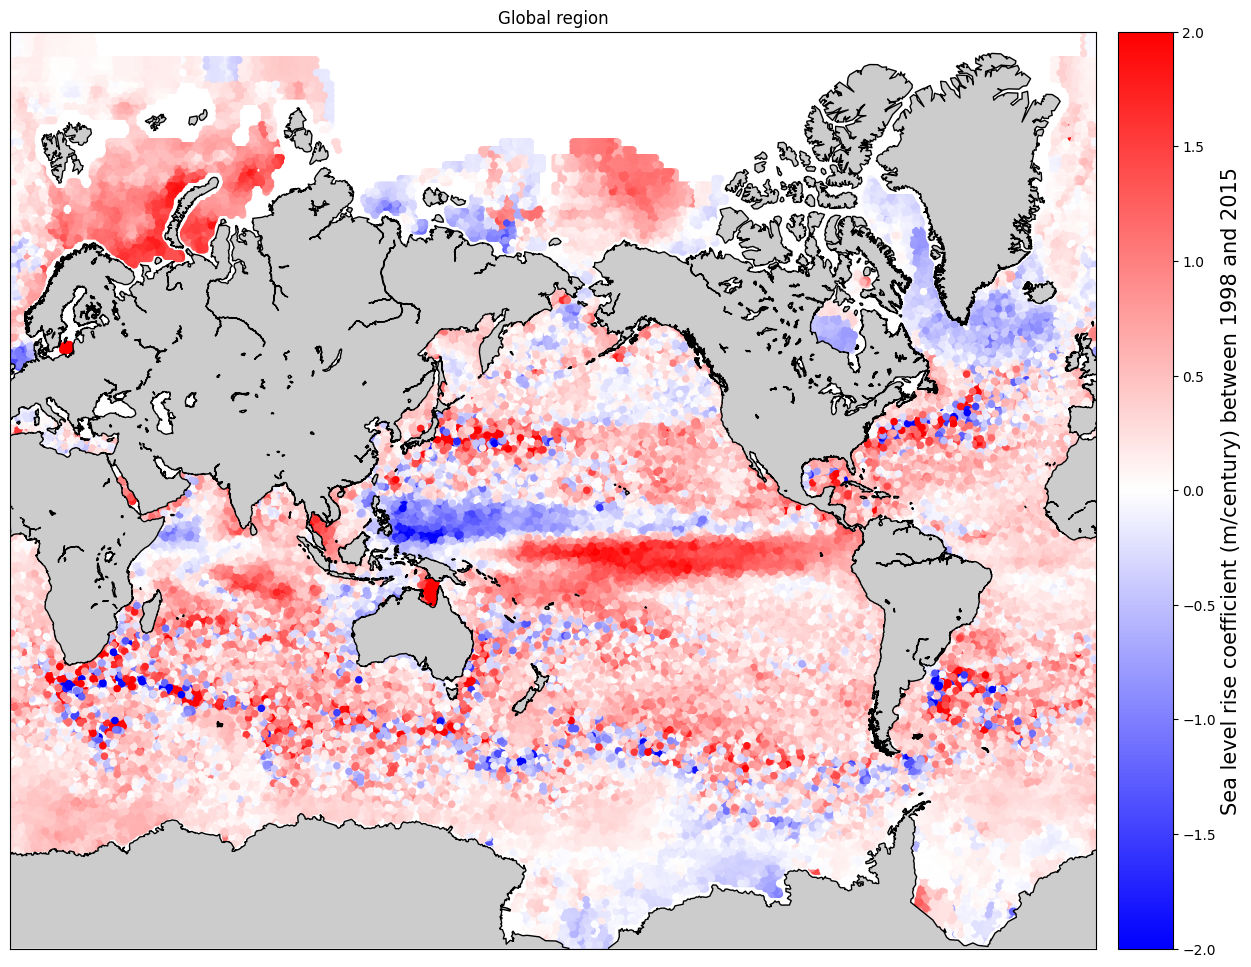

In [ ]:
plot_im2(output2.lon, output2.lat, output2.slope*100, 30, "Sea level rise coefficient (m/century) between 1998 and 2015", "Global region", mini=-2, maxi=2)

A little zoom on Brittany:

In [ ]:
bretagne = output2.where(((output2.lon>350) | (output2.lon<5)) & (output2.lat>45) & (output2.lat<53))

In [ ]:
# The interest zone is on parallel n°0, we need to adjust our plot function
def plot_im3(lon, lat, im, size_points, var_name, title, mini ,maxi):

    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)

    # Mercator projection (for small zone)
    m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
              llcrnrlon=350,urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
              lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')

    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)

    # transform (lon,lat) to (x,y)
    x, y = m(lon, lat)

    # plot
    im = ma.masked_where(isnan(im), im)
    res = m.scatter(x, y, size_points, im, 'o', alpha=1, vmin=mini, vmax=maxi, cmap='bwr', lw=0)
    plt.title(title, fontsize=20)
    m.drawcoastlines()
    m.fillcontinents()
    #parallels = linspace(nanmin(lat), nanmax(lat), 15)
    #meridians = linspace(nanmin(lon), nanmax(lon), 15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb = m.colorbar(res, location="right")
    cb.set_label(var_name, fontsize=15)
    plt.savefig(title + ".png")

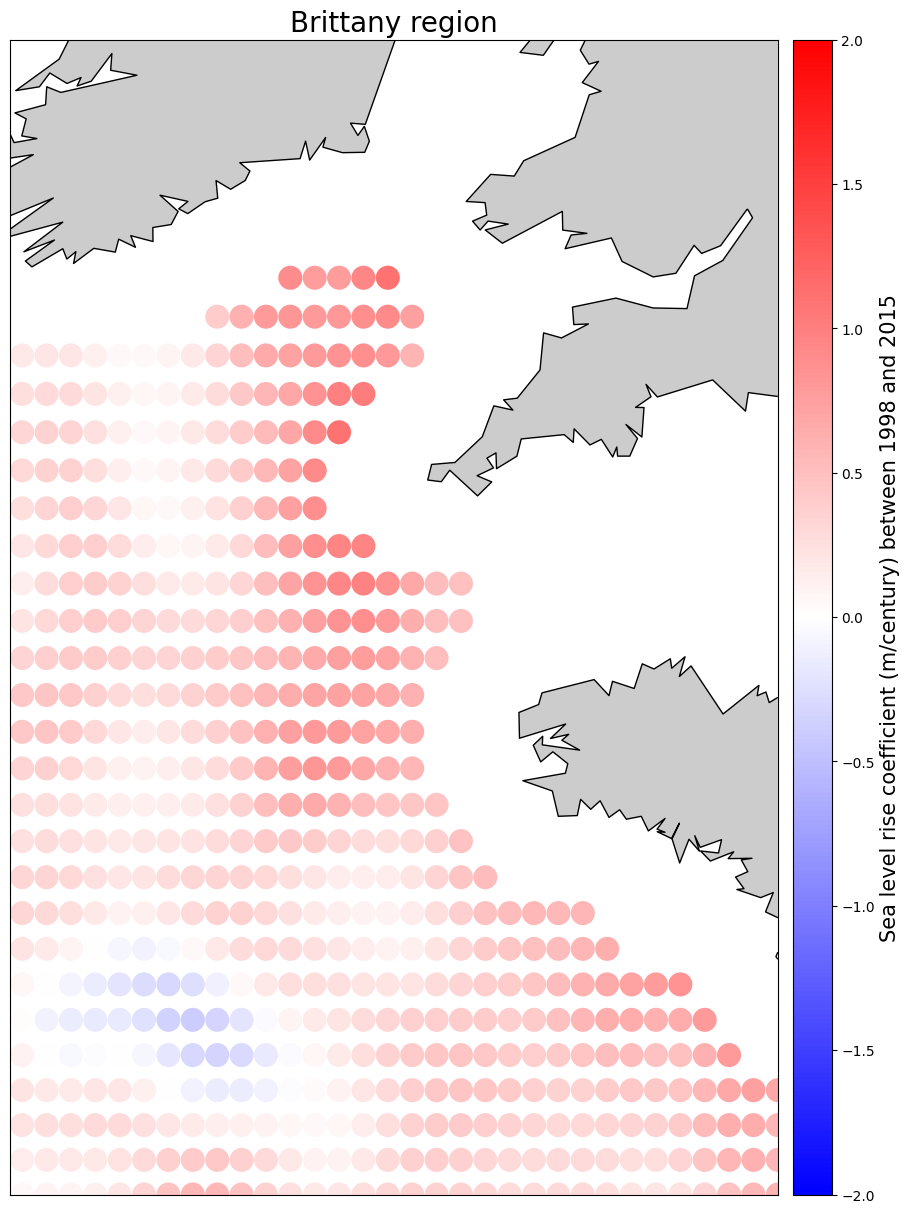

In [ ]:
plot_im3(bretagne.lon, bretagne.lat, bretagne.slope*100, 300, "Sea level rise coefficient (m/century) between 1998 and 2015", "Brittany region", mini=-2, maxi=2)

Finally, we focus on the Pacific region, where sea level is intense and entire countries may be flooded over.

In [ ]:
kiribati = output2.where((output2.lon>150) & (output2.lon<190) & (output2.lat>-30) & (output2.lat<15))

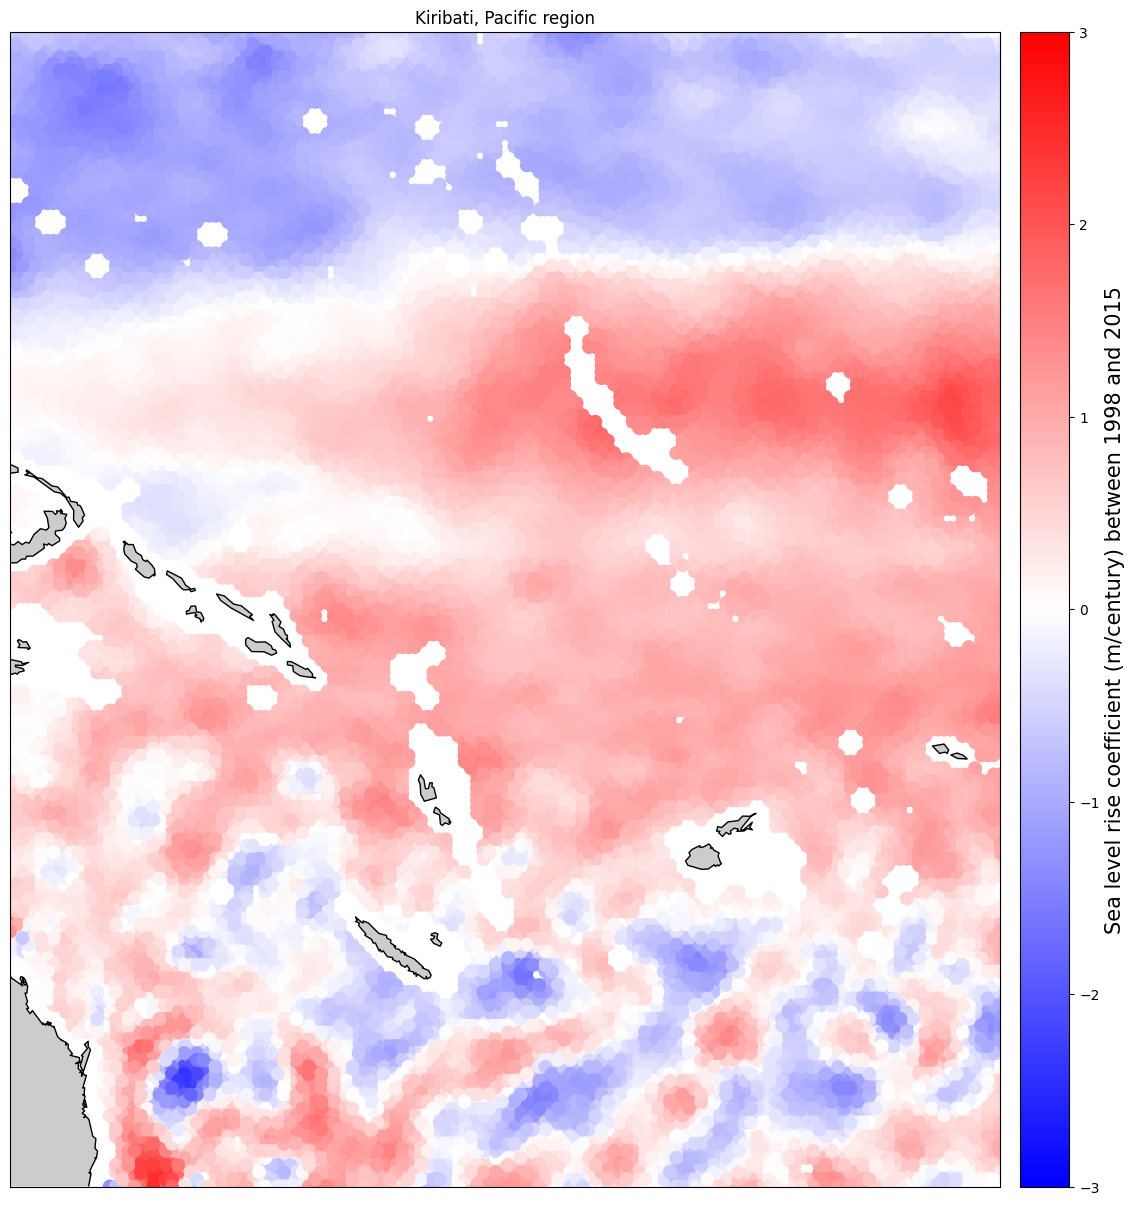

In [ ]:
plot_im2(kiribati.lon, kiribati.lat, kiribati.slope*100, 100, "Sea level rise coefficient (m/century) between 1998 and 2015", "Kiribati, Pacific region", mini=-3, maxi=3)